In [1]:
from scipy.stats import kde
import h5py
import astropy.io.fits as fits
import csv
import pandas as pd
import numpy as np
import tables
import pickle
import os
from astropy.table import Table
from astropy.coordinates import SkyCoord
from tqdm import tqdm
from astropy.io import ascii
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import incredible as cr
from scipy.special import erf
from scipy import stats
import scipy.optimize as opt
from scipy import stats
import scipy.optimize as opt
import emcee
import tqdm

In [2]:
import warnings
warnings.filterwarnings("ignore")

### On the RM Catalog

The subscripts _x denote the central galaxy properties and _y denote all galaxies. We removed double counts of the central galaxy

In [3]:
with open('RM_SDSS_df.pkl', 'rb') as handle:
    RM_df = pickle.load(handle)

In [4]:
rm_data = Table.from_pandas(RM_df)

In [69]:
##Remove clusters with bad spectroscopic redshift. 
cut = np.where((rm_data['Z_SPEC_x'] > 0) &\
               (rm_data['Z_SPEC_y'] >0) &\
               (rm_data['Z_SPEC_y'] != rm_data['Z_SPEC_x']))
rm_data = rm_data[cut]

In [70]:
rm_data.columns

<TableColumns names=('ID','NAME','RA_x','DEC_x','Z_LAMBDA','Z_LAMBDA_ERR','LAMBDA','LAMBDA_ERR','S','Z_SPEC_x','OBJID_x','IMAG_x','IMAG_ERR_x','MODEL_MAG_U_x','MODEL_MAGERR_U_x','MODEL_MAG_G_x','MODEL_MAGERR_G_x','MODEL_MAG_R_x','MODEL_MAGERR_R_x','MODEL_MAG_I_x','MODEL_MAGERR_I_x','MODEL_MAG_Z_x','MODEL_MAGERR_Z_x','ILUM','RA_y','DEC_y','R','P','P_FREE','THETA_I','THETA_R','IMAG_y','IMAG_ERR_y','MODEL_MAG_U_y','MODEL_MAGERR_U_y','MODEL_MAG_G_y','MODEL_MAGERR_G_y','MODEL_MAG_R_y','MODEL_MAGERR_R_y','MODEL_MAG_I_y','MODEL_MAGERR_I_y','MODEL_MAG_Z_y','MODEL_MAGERR_Z_y','Z_SPEC_y','OBJID_y','R_LAMBDA','z_diff')>

In [71]:
rm_data['z_diff'] = (rm_data['Z_SPEC_y']-rm_data['Z_SPEC_x'])/(1+rm_data['Z_SPEC_x'])

In [72]:
rm_data.remove_rows(np.where(rm_data['z_diff']==0)[0])

## Do z_diff for RM clusters
_y refers to the galaxies

_x is for the central BCG or the cluster property

In [73]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling import models
from astropy.modeling.polynomial import Chebyshev1D, Polynomial1D
from astropy.modeling.functional_models import Linear1D
from astropy import units as u
from specutils.spectra import Spectrum1D, SpectralRegion
from specutils.fitting import fit_generic_continuum
import linetools

In [74]:
from specutils import SpectralRegion
exclude_regions = [SpectralRegion(-0.05 * u.um, 0.05 * u.um)]

In [75]:
#Bin by richness
lmda_bins = [[20,30],[30,50],[50,300]] #upper limit must match lower limit of next bin

## Bin by redshift
z_bins = [[0.15,0.2],[0.2,0.3],[0.3,0.4]]

In [76]:
small_bin = np.linspace(-0.01,0.01,101)
wide_bin_1 = np.linspace(-0.2,-0.01,51)
wide_bin_2 = np.linspace(0.01,0.2,51)

binBoundaries = np.hstack((wide_bin_1, small_bin))
binBoundaries = np.hstack((binBoundaries, wide_bin_2))
binCent = np.asarray([(binBoundaries[i] + binBoundaries[i+1])/2 for i in range(len(binBoundaries)-1)])

In [77]:
val, bin_edges= np.histogram(rm_data['z_diff'], bins=binBoundaries, density=True)
#numCount, bin_edges = np.histogram(z_diff, bins=binBoundaries, density=False) 

##For Poissonian noise
#numCount[np.where(numCount<=0)] = 1 #Avoid dividing by 0 or NAN
#y_err = np.sqrt(numCount)
#y_err *= val/numCount
#y_err += 0.001 ## Add small number to avoid blowing up
y_err = np.sqrt(val)
y_err[np.where(y_err==0)] = 1


spectrum = Spectrum1D(flux=val*u.Jy, spectral_axis=binCent*u.um)
g1_fit = fit_generic_continuum(spectrum, model=Chebyshev1D(5), median_window=3, exclude_regions=exclude_regions)
y_continuum_fitted_1 = g1_fit(binCent*u.um)

            
##Take Poisson error before subtracting the continuum
y_err = np.sqrt(val)
y_err[np.where(y_err==0)] = 1 ## Ad hoc method to correct for bins with 0

#val -= y_continuum_fitted_1.value

(array([2.300e+01, 2.980e+02, 3.722e+03, 3.538e+04, 2.322e+03, 4.240e+02,
        1.400e+02, 3.800e+01, 1.200e+01, 1.000e+00]),
 array([-0.24467905, -0.16877526, -0.09287147, -0.01696769,  0.0589361 ,
         0.13483989,  0.21074367,  0.28664747,  0.36255124,  0.43845505,
         0.51435882]),
 <BarContainer object of 10 artists>)

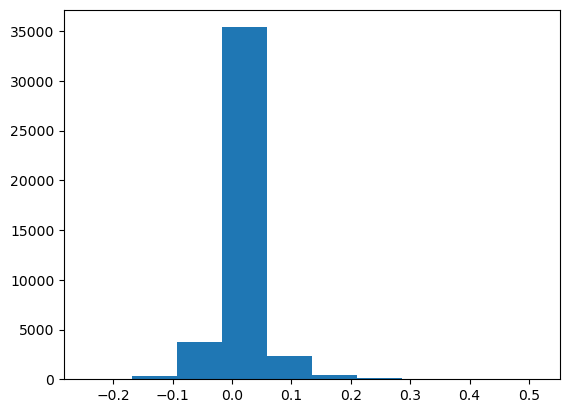

In [78]:
plt.hist(rm_data['z_diff'])

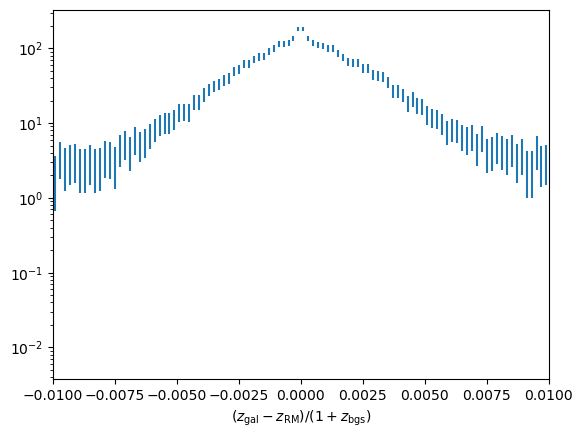

In [89]:
plt.errorbar(binCent, val, yerr=y_err, linestyle='none')
plt.xlabel(r"$(z_{\rm{gal}} - z_{\rm{RM}})/(1+z_{\rm{bgs}})$")
plt.yscale('log')
plt.xlim([-0.01,0.01])
plt.show()

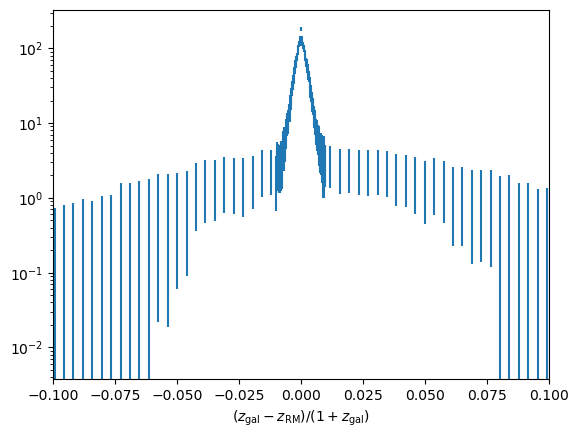

In [91]:
plt.errorbar(binCent, val, yerr=y_err, linestyle='none')
plt.xlabel(r"$(z_{\rm{gal}} - z_{\rm{RM}})/(1+z_{\rm{gal}})$")
plt.yscale('log')
plt.xlim([-0.1,0.1])
plt.show()

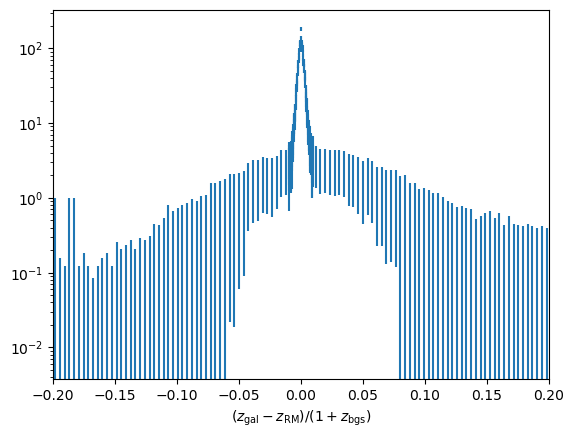

In [87]:
plt.errorbar(binCent, val, yerr=y_err, linestyle='none')
plt.xlabel(r"$(z_{\rm{gal}} - z_{\rm{RM}})/(1+z_{\rm{bgs}})$")
plt.yscale('log')
plt.xlim([-0.2,0.2])
plt.show()

## Match to BGS galaxies